# 0 Initialization #

## 0.1 Imports and Path ##

In [1]:
# Imports
# Python = 3.10.12
import numpy as np  # V1.24.3
import pandas  # V1.5.3
import warnings
import matplotlib  # V3.7.1
import xgboost  # V1.7.3
import shap  # V0.42.1
from sklearn.metrics import r2_score as r2s  # V1.3.0
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.base import is_regressor
from sklearn import clone
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.preprocessing import MinMaxScaler as Scaler
from matplotlib import pyplot as plt
# <editor-fold desc="Protected Imports">
from sklearn.utils import check_random_state, _safe_indexing
from sklearn.utils.validation import _num_samples, _check_sample_weight
# </editor-fold>

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Path of data and output
path_tar, col_tar = r'C:\Users\Administrator\Desktop\Open Source\FRP_Dataset.xls', 'I'
path_sou, col_sou = r'C:\Users\Administrator\Desktop\Open Source\Steel_Dataset.xls', 'I'
save_path = r'C:\Users\Administrator\Desktop\Open Source\Results\Re_'

## 0.2 Define algorithm classes ##

### 0.2.1 TrAdaBoost ###

In [3]:
class TrAdaBoostR:
    def __init__(self, learner):
        self.learner = learner
        self.weight = 0
        self.p, self.err, self.beta_t, self.p_train = None, None, None, None
        self.learners = []
        self.n_iters = 20

    def fit(self, x_source: np.ndarray, y_source: np.ndarray, x_target: np.ndarray, y_target: np.ndarray,
            n_iters: int = 20):
        self.n_iters = n_iters
        y_source, y_target = np.ravel(y_source), np.ravel(y_target)
        n, m = y_source.shape[0], y_target.shape[0]  # Data Points (diff and same distribution)
        x_train = np.concatenate((x_source, x_target), axis=0)
        y_train = np.concatenate((y_source, y_target), axis=0)
        self.weight = np.zeros((n_iters, n + m))
        self.weight[0] = np.ones(n + m) / (n + m)
        self.p = np.zeros((n_iters, n + m))
        self.p_train = np.zeros((n_iters, n + m))
        self.err = np.zeros(n_iters)
        self.beta_t = np.zeros(n_iters)
        for t in range(n_iters):
            self.p[t] = self.weight[t] / self.weight[t].sum()
            learner = clone(self.learner)
            learner.fit(x_train, y_train, sample_weight=self.p[t])
            self.p_train[t] = learner.predict(x_train)
            self.learners.append(learner)
            loss = self.p_train[t, :] - y_train
            l1_same = np.max(np.abs(loss[n:n + m]))
            weight_same = self.weight[t, n:n + m].sum()
            for i in range(n, n + m):
                self.err[t] += abs(self.p_train[t, i] - y_train[i]) * self.weight[t, i] / weight_same / l1_same
            if self.err[t] >= 0.5:
                self.p = self.p[:t, :]
                self.err = self.err[:t]
                self.beta_t = self.beta_t[:t]
                self.p_train = self.p_train[:t, :]
                break
            self.beta_t[t] = self.err[t] / (1 - self.err[t])
            beta = 1 / (1 + (2 * np.log(n) / n_iters) ** 0.5)
            l1_diff = np.max(np.abs(loss[0:n]))
            if t == n_iters - 1:
                break
            for i in range(n):
                self.weight[t + 1, i] = self.weight[t, i] * beta ** (abs(self.p_train[t, i] - y_train[i]) / l1_diff)
            for i in range(n, n + m):
                self.weight[t + 1, i] = self.weight[t, i] * self.beta_t[t] ** \
                                        (- abs(self.p_train[t, i] - y_train[i]) / l1_same)

    def predict(self, x: np.ndarray):
        weights = self.beta_t / self.beta_t.sum()
        predicts = None
        for reg in self.learners:
            p_x = reg.predict(x)
            p_x = p_x.reshape(p_x.shape[0], 1)
            if predicts is None:
                predicts = p_x
            else:
                predicts = np.concatenate([predicts, p_x], axis=1)
        return predicts.mean(axis=1)

### 0.2.2 Two-stage TrAdaboost ###

In [4]:
class AdaBoostR2T(AdaBoostRegressor):
    n_protected = 0
    sample_weight = None

    def fit(self, X, y, sample_weight=None):
        self._validate_params()

        X, y = self._validate_data(
            X,
            y,
            accept_sparse=["csr", "csc"],
            ensure_2d=True,
            allow_nd=True,
            dtype=None,
            y_numeric=is_regressor(self),
        )

        sample_weight = _check_sample_weight(
            sample_weight, X, np.float64, copy=True, only_non_negative=True
        )
        sample_weight /= sample_weight.sum()

        # Check parameters
        self._validate_estimator()

        # Clear any previous fit results
        self.estimators_ = []
        self.estimator_weights_ = np.zeros(self.n_estimators, dtype=np.float64)
        self.estimator_errors_ = np.ones(self.n_estimators, dtype=np.float64)

        # Initialization of the random number instance that will be used to
        # generate a seed at each iteration
        random_state = check_random_state(self.random_state)
        epsilon = np.finfo(sample_weight.dtype).eps

        zero_weight_mask = sample_weight == 0.0
        for iboost in range(self.n_estimators):
            # avoid extremely small sample weight, for details see issue #20320
            sample_weight = np.clip(sample_weight, a_min=epsilon, a_max=None)
            # do not clip sample weights that were exactly zero originally
            sample_weight[zero_weight_mask] = 0.0

            # Boosting step
            sample_weight, estimator_weight, estimator_error = self._boost(
                iboost, X, y, sample_weight, random_state
            )

            # Early termination
            if sample_weight is None:
                break
            self.estimator_weights_[iboost] = estimator_weight
            self.estimator_errors_[iboost] = estimator_error

            # Stop if error is zero
            if estimator_error == 0:
                break

            sample_weight_sum = np.sum(sample_weight)

            if not np.isfinite(sample_weight_sum):
                warnings.warn(
                    "Sample weights have reached infinite values,"
                    f" at iteration {iboost}, causing overflow. "
                    "Iterations stopped. Try lowering the learning rate.",
                    stacklevel=2,
                )
                break

            # Stop if the sum of sample weights has become non-positive
            if sample_weight_sum <= 0:
                break
            # =======  override  =======
            sum_n = np.sum(sample_weight[:self.n_protected])
            sum_m = np.sum(sample_weight[self.n_protected:])
            if iboost < self.n_estimators - 1:
                # Normalize m samples while n are protected
                sample_weight[self.n_protected:] *= (1 - sum_n) / sum_m
            self.sample_weight = sample_weight
            # ==========================
        return self

    def _boost(self, iboost, X, y, sample_weight, random_state):
        estimator = self._make_estimator(random_state=random_state)

        # Weighted sampling of the training set with replacement
        bootstrap_idx = random_state.choice(
            np.arange(_num_samples(X)),
            size=_num_samples(X),
            replace=True,
            p=sample_weight,
        )

        # Fit on the bootstrapped sample and obtain a prediction
        # for all samples in the training set
        X_ = _safe_indexing(X, bootstrap_idx)
        y_ = _safe_indexing(y, bootstrap_idx)
        estimator.fit(X_, y_)
        y_predict = estimator.predict(X)

        error_vect = np.abs(y_predict - y)
        sample_mask = sample_weight > 0

        # ========  override  ========
        # freeze first n's weight
        sample_mask[:self.n_protected].fill(False)
        # ============================

        masked_sample_weight = sample_weight[sample_mask]
        masked_error_vector = error_vect[sample_mask]
        error_max = masked_error_vector.max()
        if error_max != 0:
            masked_error_vector /= error_max

        if self.loss == "square":
            masked_error_vector **= 2
        elif self.loss == "exponential":
            masked_error_vector = 1.0 - np.exp(-masked_error_vector)

        # Calculate the average loss
        estimator_error = (masked_sample_weight * masked_error_vector).sum()

        if estimator_error <= 0:
            # Stop if fit is perfect
            return sample_weight, 1.0, 0.0

        elif estimator_error >= 0.5:
            # Discard current estimator only if it isn't the only one
            if len(self.estimators_) > 1:
                self.estimators_.pop(-1)
            return None, None, None

        beta = estimator_error / (1.0 - estimator_error)

        # Boost weight using AdaBoost.R2 alg
        estimator_weight = self.learning_rate * np.log(1.0 / beta)

        if not iboost == self.n_estimators - 1:
            sample_weight[sample_mask] *= np.power(
                beta, (1.0 - masked_error_vector) * self.learning_rate
            )

        return sample_weight, estimator_weight, estimator_error

    def set_protected(self, n_protected):
        self.n_protected = n_protected


class TwoStageTrAdaboost:
    s = 20  
    regs = []  
    learner = None
    w = None  
    train_indicator, valid_indicator = {}, {}
    verification, display_warning = False, False
    n = 0
    last_regressor = 0
    boost_learner = None
    beta_record = []
    random_state = 0

    def __init__(self, steps: int = 20, base_learner=None, boost_learner=AdaBoostR2T()
                 , display_warning: bool = False, random_state=0):
        from sklearn.tree import DecisionTreeRegressor
        self.s = steps
        self.display_warning = display_warning
        if base_learner is None:
            self.learner = DecisionTreeRegressor(max_depth=3, random_state=self.random_state)
        else:
            self.learner = base_learner
        self.regs = []
        self.w = None
        self.train_indicator, self.valid_indicator = {}, {}
        self.verification, self.display_warning = False, False
        self.n = 0
        self.last_regressor = 0
        self.boost_learner = boost_learner
        self.beta_record = []

    def fit(self, x_source: np.ndarray, y_source: np.ndarray, x_target: np.ndarray, y_target: np.ndarray):
        from sklearn.metrics import r2_score as r2s
        n, m = len(y_source), len(y_target)
        self.n = n
        self.w = np.zeros((self.s, n + m))
        self.w[0, :] = np.ones(n + m) / (n + m)
        x_train = np.concatenate((x_source, x_target), axis=0)
        y_train = np.concatenate((y_source, y_target), axis=0)
        for t in range(self.s):
            r2t = AdaBoostR2T(estimator=self.learner, learning_rate=0.5, n_estimators=20, loss='square',
                              random_state=self.random_state)
            r2t.set_protected(n)  # freeze first n instances
            r2t.fit(x_train, y_train, sample_weight=self.w[t, :])
            self.regs.append(r2t)
            learner = self.learner
            learner.fit(x_train, y_train, sample_weight=self.w[t, :])
            hyp_train = learner.predict(x_train)
            e_learner = np.abs(y_train - hyp_train)
            e_t = e_learner / np.max(e_learner)
            if t == self.s - 1:
                break
            beta_0, beta_1 = -20, 1
            target_sum = m / (n + m) + t / (self.s - 1) * (1 - m / (n + m))
            curr_sum = 10
            while abs(target_sum - curr_sum) > 10 ** -3:
                curr_beta = beta_0 / 2 + beta_1 / 2
                self.w[t + 1, :n] = self.w[t, :n] * np.power(10 ** curr_beta, e_t[:n])
                self.w[t + 1, n:] = self.w[t, n:]
                self.w[t + 1] /= np.sum(self.w[t + 1])  # Normalize
                curr_sum = np.sum(self.w[t + 1, n:])
                if curr_sum > target_sum:
                    beta_0 = (beta_0 + beta_1) / 2
                else:
                    beta_1 = (beta_0 + beta_1) / 2
                if beta_1 - beta_0 < 10 ** -10:
                    if not self.display_warning:
                        break
                    print('Convergence Failed in Iter {3} with E = {0:.4f}'
                          .format(target_sum - curr_sum, beta_0, beta_1, t))
                    break
            self.beta_record.append(10 ** beta_0)
        n_4 = len(self.regs)
        r2_target, mae_target, mse_target = np.zeros(n_4), np.zeros(n_4), np.zeros(n_4)
        for i in range(n_4):
            p_train = self.regs[i].predict(x_train)
            r2_target[i] = r2s(y_train[n:], p_train[n:])
            mae_target[i] = np.mean(np.abs(y_train[n:] - p_train[n:]))
            mse_target[i] = np.mean((y_train[n:] - p_train[n:]) ** 2)
        self.train_indicator['r2_target'] = r2_target
        self.train_indicator['mae_target'] = mae_target
        self.train_indicator['mse_target'] = mse_target
        self.verification = False

    def valid(self, x_valid: np.ndarray, y_valid: np.ndarray):
        from sklearn.metrics import r2_score as r2s
        n_4 = len(self.regs)
        n = self.n
        r2, mae, mse = np.zeros(n_4), np.zeros(n_4), np.zeros(n_4)
        for i in range(n_4):
            p_valid = self.regs[i].predict(x_valid)
            r2[i] = r2s(y_valid, p_valid)
            mae[i] = np.mean(np.abs(y_valid - p_valid))
            mse[i] = np.mean((y_valid - p_valid) ** 2)
        self.valid_indicator['r2'] = r2
        self.valid_indicator['mae'] = mae
        self.valid_indicator['mse'] = mse
        self.verification = True

    def predict(self, x: np.ndarray, principle='mae', valid_indicator=True):
        if not self.verification:
            raise AssertionError('No Validation Present.')
        reg_principle = self.valid_indicator.get(principle)
        reg_arg = np.argmin(reg_principle)
        reg = self.regs[reg_arg]
        self.last_regressor = reg_arg
        return reg.predict(x)

### 0.2.3 Proposed Algorithm ###

In [5]:
class ProposedAlg:
    s = 20  # Hyperparameter S : the number of steps
    regs = []  # Regressor saved
    learner = None
    w = None  # Weight
    train_indicator, valid_indicator = {}, {}
    verification, display_warning = False, False
    n = 0
    last_regressor = 0
    boost_learner = None
    beta_record = []
    feature_importance = None

    def __init__(self, steps: int = 20, base_learner=None, boost_learner=None
                 , display_warning: bool = False):
        from sklearn.tree import DecisionTreeRegressor
        self.s = steps
        self.display_warning = display_warning
        if base_learner is None:
            self.learner = DecisionTreeRegressor(max_depth=3)
        else:
            self.learner = base_learner
        if boost_learner is None:
            self.boost_learner = AdaBoostR2T()
        else:
            self.boost_learner = boost_learner
        self.regs = []
        self.w = None
        self.train_indicator, self.valid_indicator = {}, {}
        self.verification, self.display_warning = False, False
        self.n = 0
        self.last_regressor = 0
        self.boost_learner = boost_learner
        self.beta_record = []

    def fit(self, x_source: np.ndarray, y_source: np.ndarray, x_target: np.ndarray, y_target: np.ndarray):
        from sklearn.metrics import r2_score as r2s
        from sklearn.base import clone
        n, m = len(y_source), len(y_target)
        self.n = n
        self.w = np.zeros((self.s, n + m))
        self.w[0, :] = np.ones(n + m) / (n + m)
        x_train = np.concatenate((x_source, x_target), axis=0)
        y_train = np.concatenate((y_source, y_target), axis=0)
        for t in range(self.s):
            r2t = clone(self.boost_learner)
            r2t.fit(x_train, y_train, sample_weight=self.w[t, :])
            self.regs.append(r2t)
            learner = clone(self.learner)
            learner.fit(x_train, y_train, sample_weight=self.w[t, :])
            hyp_train = learner.predict(x_train)
            e_learner = np.abs(y_train - hyp_train)
            e_t = e_learner / np.max(e_learner)
            if t == self.s - 1:
                break
            beta_0, beta_1 = -20, 1
            target_sum = m / (n + m) + t / (self.s - 1) * (1 - m / (n + m))
            curr_sum = 10
            while abs(target_sum - curr_sum) > 10 ** -3:
                curr_beta = beta_0 / 2 + beta_1 / 2
                self.w[t + 1, :n] = self.w[t, :n] * np.power(10 ** curr_beta, e_t[:n])
                self.w[t + 1, n:] = self.w[t, n:]
                self.w[t + 1] /= np.sum(self.w[t + 1])
                curr_sum = np.sum(self.w[t + 1, n:])
                if curr_sum > target_sum:
                    beta_0 = (beta_0 + beta_1) / 2
                else:
                    beta_1 = (beta_0 + beta_1) / 2
                if beta_1 - beta_0 < 10 ** -10:
                    if not self.display_warning:
                        break
                    print('Convergence Failed in Iter {3} with E = {0:.4f}'
                          .format(target_sum - curr_sum, beta_0, beta_1, t))
                    break
            self.beta_record.append(10 ** beta_0)
        n_4 = len(self.regs)
        r2_target, mae_target, mse_target = np.zeros(n_4), np.zeros(n_4), np.zeros(n_4)
        for i in range(n_4):
            p_train = self.regs[i].predict(x_train)
            r2_target[i] = r2s(y_train[n:], p_train[n:])
            mae_target[i] = np.mean(np.abs(y_train[n:] - p_train[n:]))
            mse_target[i] = np.mean((y_train[n:] - p_train[n:]) ** 2)
        self.train_indicator['r2_target'] = r2_target
        self.train_indicator['mae_target'] = mae_target
        self.train_indicator['mse_target'] = mse_target
        self.verification = False

    def predict(self, x: np.ndarray, principle='mae'):
        reg_principle = self.train_indicator.get(principle + '_target')
        reg_arg = reg_principle < np.median(reg_principle)
        self.last_regressor = reg_arg
        predicts = np.zeros([x.shape[0], 1])
        for i in range(len(self.regs)):
            if reg_arg[i]:
                curr_predict = self.regs[i].predict(x)
                predicts = np.concatenate([predicts, curr_predict.reshape([curr_predict.shape[0], 1])], axis=1)
        predicts = predicts[:, 1:]
        return np.mean(predicts, axis=1)

## 0.3 Base Methods for main process ##

In [6]:
def load_data(d_path: str, label_col_str: str, feature_col_str: str = 'B', c_index: bool = False):
    import pandas as pd
    # get column index
    label_col, count = 0, 0
    for i in label_col_str:
        count += 1
        if len(label_col_str) - count == 1:
            label_col += (ord(i.lower()) - 96) * 26
        else:
            label_col += (ord(i.lower()) - 96)
    feature_col, count = 0, 0
    for i in feature_col_str:
        count += 1
        if len(feature_col_str) - count == 1:
            feature_col += (ord(i.lower()) - 96) * 26
        else:
            feature_col += (ord(i.lower()) - 96)
    # get data
    db = pd.read_excel(d_path)
    x = db.iloc[:, feature_col - 1:label_col - 1]
    y = db.iloc[:, label_col - 1]
    x_index = x.columns.to_list()
    y_index = y.name
    x = np.array(x, dtype='float64')
    y = np.array(y, dtype='float64')
    if c_index:
        return x, y, x_index, y_index
    else:
        return x, y

In [7]:
def load_data_line(d_path: str, col_index: str):
    import pandas as pd
    label_col, count = 0, 0
    for i in col_index:
        count += 1
        if len(col_index) - count == 1:
            label_col += (ord(i.lower()) - 96) * 26
        else:
            label_col += (ord(i.lower()) - 96)
    db = pd.read_excel(d_path)
    y = db.iloc[:, label_col - 1]
    return y

In [8]:
def get_subplot_id(n_row: int, n_col: int, curr_id: int):
    curr_row = 0
    while curr_id >= n_row:
        curr_row += 1
        curr_id -= n_row
    return curr_row, curr_id

In [9]:
def sort_lists(a: list, b: list, reverse=True):
    d = dict(zip(a, b))
    a_sorted = sorted(d, reverse=reverse)
    b_sorted = []
    for i in a_sorted:
        b_sorted.append(d.get(i))
    return a_sorted, b_sorted

In [10]:
def a20_index(true_values: np.ndarray, predict_values: np.ndarray, variation: float = 0.2) -> float:
    m20 = 0
    for ii, jj in zip(true_values, predict_values):
        if jj * (1-variation) <= ii <= jj * (1+variation):
            m20 += 1
    return m20 / true_values.shape[0]

In [11]:
def fractional_bias(true_values: np.ndarray, predict_values: np.ndarray) -> float:
    a_sub_p = true_values - predict_values
    a_add_p = true_values + predict_values
    return 2 * a_sub_p.sum() / a_add_p.sum()

# 1 Import Data #

In [12]:
x_original_tar, y_tar, x_name, y_name = load_data(path_tar, col_tar, c_index=True)
x_original_s, ys = load_data(path_sou, col_sou)
ids = load_data_line(path_tar, 'A').tolist()
feature_names = ['$A_{core}$', "$f_{co}'$", '$d_t$', '$s_t$', '$E_t$', '$f_{fu}$', '$Shape$']
feature_units = ['(mm$^2$)', '(MPa)', '(mm)', '(mm)', '(GPa)', '(MPa)', '']
label_name = '$f_{cc}\'$'

# 2 Data Vision #

In [13]:
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['Times New Roman']
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['mathtext.rm'] = 'font.serif'
matplotlib.rcParams['font.size'] = 12.5

## 2.1 Features vs Label ##

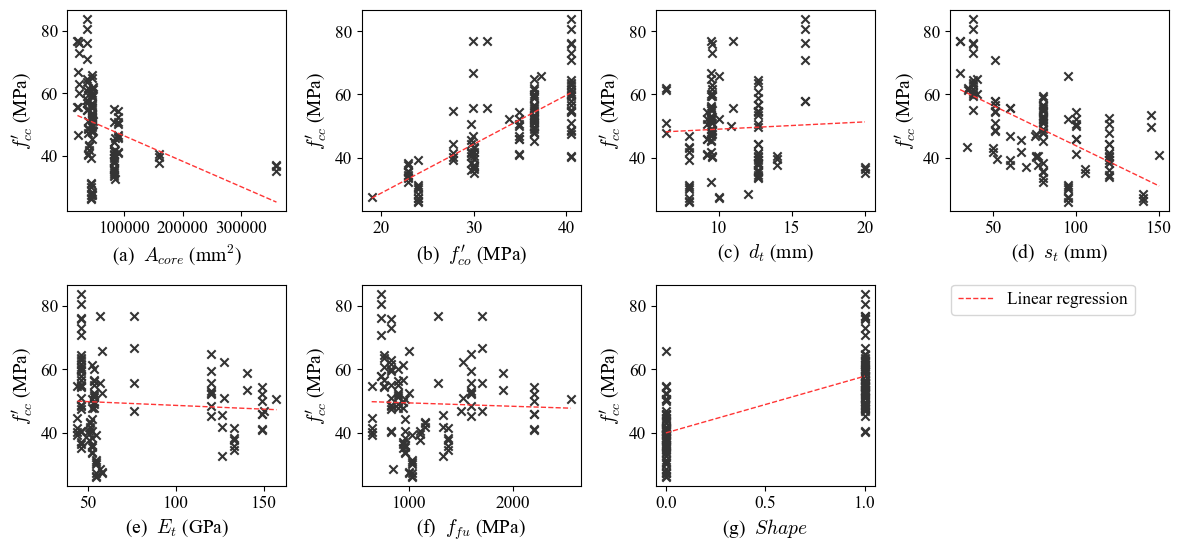

In [14]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(12, 5.7))
fig.subplots_adjust(top=0.967, bottom=0.131, left=0.063, right=0.981, hspace=0.364, wspace=0.344)
for i, (ax, col) in enumerate(zip(axs.flat, feature_names)):
    x = x_original_tar[:, i]
    ax.scatter(x, y_tar, c='#343434', marker='x')
    if i != 7:
        lin_x = np.linspace(x.min(), x.max(), 20)
        pf = np.polyfit(x, y_tar, 1)
        pf.resize(pf.size)
        p = np.poly1d(pf)
        ax.plot(lin_x, p(lin_x), ls='dashed', lw=1, c='#FF3535', label='Linear regression')
    ax.set_xlabel('(' + chr(97+i) + ')  ' + col + ' ' + feature_units[i], fontsize=14)
    ax.set_ylabel(label_name + ' (MPa)', fontsize=14)
    if i == len(feature_names):
        break
plt.delaxes(axs[1, 3])
axs[1, 2].legend(loc=2, bbox_to_anchor=(1.35, 1.0), borderaxespad=0)
plt.show()

## 2.2 Features vs Features ##

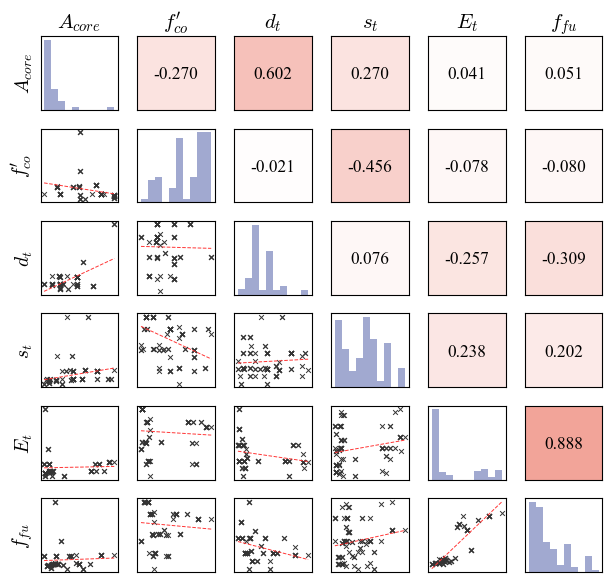

In [15]:
x4plot = x_original_tar[:, :-1]
corr_matrix = pandas.DataFrame(x4plot)
corr_matrix = corr_matrix.corr().values
corr_matrix = np.around(corr_matrix, 3)
fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(6.25, 6))
fig.subplots_adjust(top=0.924, bottom=0.031, left=0.072, right=0.971, hspace=0.255, wspace=0.255)
for i, ax in enumerate(axs.flat):
    i_col = int(i / 6)
    f_col = feature_names[i_col]
    i_row = i % 6
    f_row = feature_names[i_row]
    if i_row < i_col:
        x = x4plot[:, i_col]
        y = x4plot[:, i_row]
        pf = np.polyfit(x, y, 1)
        pf.resize(pf.size)
        p = np.poly1d(pf)
        ax.scatter(x, y, c='#343434', marker='x', s=12, linewidths=0.7)
        lin_x = np.linspace(x.min(), x.max(), 20)
        ax.plot(lin_x, p(lin_x), ls='dashed', lw=0.7, c='#FF3535')
        ax.set_xlabel(f_col)
        ax.set_ylabel(f_row)
    elif i_row == i_col:
        x = x4plot[:, i_col]
        ax.hist(x, color='#a1a9d0')
    else:
        corr_value = corr_matrix[i_col, i_row]
        corr_color = abs(corr_value)
        ax.text(0.5, 0.475, '{0:.3f}'.format(corr_value), ha='center', va='center')
        corr_color = np.array([255 - 15 * corr_color, 255 - 103 * corr_color, 255 - 115 * corr_color]) / 255
        ax.patch.set_facecolor(corr_color)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    if i_col == 0:
        ax.set_title(f_row)
    if i_row == 0:
        ax.set_ylabel(f_col, fontsize=14)
        ax.axes.yaxis.set_visible(True)
        ax.set_yticks([])
plt.show()

# 3 Build Models #

## 3.1 Model HyperParameters ##

In [16]:
# Readers can search HyperParameters by using sklearn.model_selection.RandomizedSearchCV
# and sklearn.model_selection.GridSearchCV on your own.
random_state = 282
np.random.seed(random_state)
learner = RandomForestRegressor(n_estimators=200, max_features=7, max_depth=12,
                                criterion='absolute_error', random_state=random_state)
base_learner = DecisionTreeRegressor(max_depth=15, criterion='friedman_mse', random_state=random_state)
regs = [RandomForestRegressor(n_estimators=200, max_features=7, max_depth=11,
                              criterion='poisson', random_state=random_state),
        ExtraTreesRegressor(n_estimators=200, max_features=6, max_depth=5,
                            criterion='poisson', random_state=random_state),
        AdaBoostRegressor(n_estimators=200, learning_rate=0.7740, loss='linear', random_state=random_state),
        xgboost.XGBRegressor(n_estimators=200, max_depth=15, learning_rate=1.5583,
                             reg_alpha=21.469, reg_lambda=446.24),
        #  Transfer
        TrAdaBoostR(base_learner),
        TwoStageTrAdaboost(),
        ProposedAlg(base_learner=base_learner, boost_learner=learner)
        ]
reg_names = ['RF', 'Extra Trees', 'AdaBoost.R2', 'XGBoost',
             'TrAdaBoost.R2', 'Two-stage TrAdaBoost.R2', 'proposed model']

## 3.2 Normalization ##

In [17]:
sc = Scaler()
sc.fit(x_original_tar)
x_tar, xs = sc.transform(x_original_tar), sc.transform(x_original_s)

## 3.3 Train-Test set spilt ##

In [18]:
xt, x_test, yt, y_test = train_test_split(x_tar, y_tar, test_size=0.2, random_state=random_state)

## 3.4 Model Training ##

In [19]:
p_trains, p_tests = [], []
metrics = []
metric_names = ['R2_train', 'R2_test', 'RMSE', 'MAE', 'MAPE', 'a20_index', 'Fractional bias']
for i in range(len(regs)):
    if regs[i] is None:
        continue
    reg = regs[i]
    if i <= 3:  # 0, 1, 2, 3
        reg.fit(xt, yt)
    elif i == 5:  # 5
        x_train, x_valid, y_train, y_valid = train_test_split(xt, yt,
                                                              test_size=0.2, random_state=random_state)
        reg.fit(xs, ys, x_train, y_train)
        reg.valid(x_valid, y_valid)
    else:  # 4, 6
        reg.fit(xs, ys, xt, yt)
    p_train, p_test = reg.predict(xt), reg.predict(x_test)
    p_trains.append(p_train)
    p_tests.append(p_test)
    # Metrics
    metric = [r2s(yt, p_train),
              r2s(y_test, p_test),
              mean_squared_error(y_test, p_test) ** 0.5,
              mean_absolute_error(y_test, p_test),
              mean_absolute_percentage_error(y_test, p_test),
              a20_index(y_test, p_test),
              fractional_bias(y_test, p_test)]
    metrics.append(np.array(metric, dtype='float64'))

In [20]:
df = pandas.DataFrame(metric_names)
for i in range(len(metrics)):
    df.insert(df.shape[1], reg_names[i], metrics[i])

In [21]:
df

,0,RF,Extra Trees,AdaBoost.R2,XGBoost,TrAdaBoost.R2,Two-stage TrAdaBoost.R2,proposed model
0,R2_train,0.940457,0.930787,0.905094,0.898606,0.948072,0.862264,0.937819
1,R2_test,0.839636,0.862437,0.860983,0.864086,0.847657,0.754146,0.908929
2,RMSE,5.833607,5.403001,5.431481,5.370504,5.685841,7.223085,4.396174
3,MAE,4.230050,4.248185,4.458750,4.160045,4.415099,5.547088,3.547122
4,MAPE,0.080957,0.082549,0.090076,0.085079,0.088149,0.108245,0.072507
5,a20_index,0.909091,0.954545,0.954545,0.954545,0.954545,0.863636,1.000000
6,Fractional bias,0.036097,0.030450,0.019304,0.033119,0.026851,0.039007,0.018698


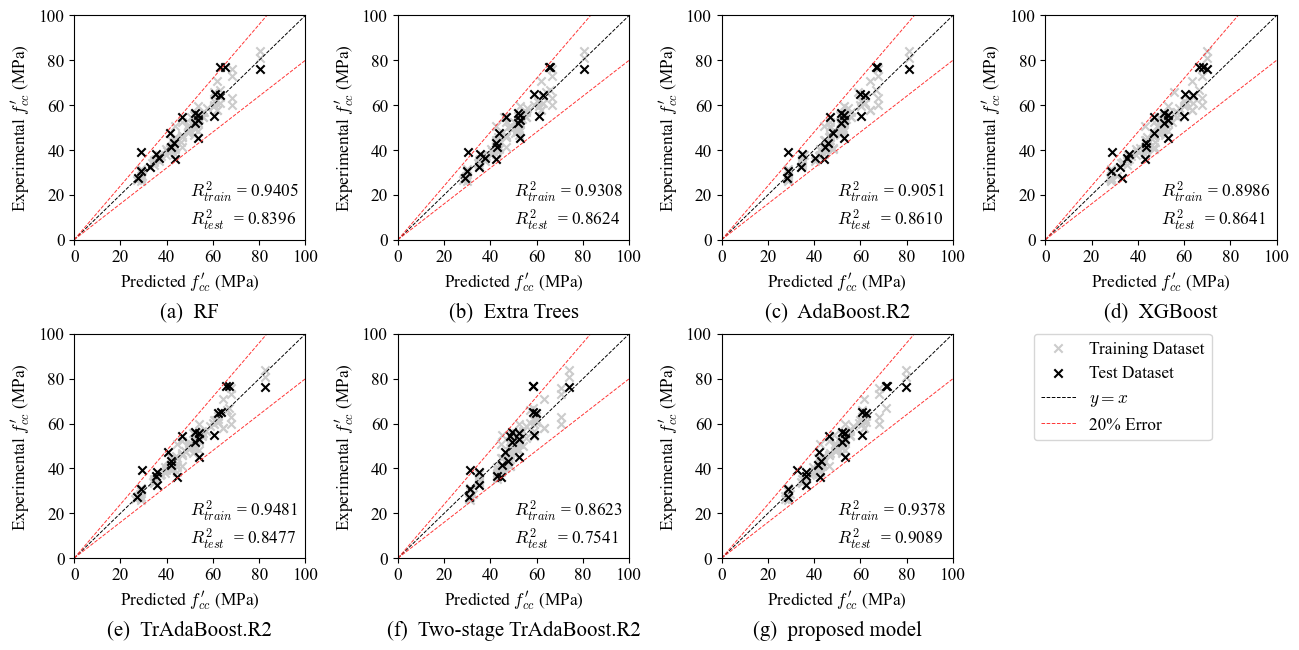

In [22]:
fig, axs = plt.subplots(2, 4, figsize=(13, 6.5))
plt.subplots_adjust(top=0.965, bottom=0.130, left=0.06, right=0.985, hspace=0.420, wspace=0.400)
y_train = yt
plot_scale = [0, 0]
plot_scale[0] = 0
for arr1, arr2 in zip(p_trains, p_tests):
    plot_scale[1] = max(arr1.max(), arr2.max()) * 1.2
plot_scale[1] = 100
xy_ticks = np.linspace(0, 100, 6)
for i in range(len(regs)):
    if regs[i] is None:
        continue
    ax_i, ax_j = get_subplot_id(4, 2, i)
    p_train, p_test = p_trains[i], p_tests[i]
    axs[ax_i, ax_j].scatter(p_train, y_train, marker='x', c=[[0.8, 0.8, 0.8]], label='Training Dataset')
    axs[ax_i, ax_j].scatter(p_test, y_test, marker='x', c=[[0, 0, 0]], label='Test Dataset')
    xn = np.linspace(plot_scale[0], plot_scale[1], 3)
    axs[ax_i, ax_j].plot(xn, xn, c='black', ls='--', lw=0.7, label='$y=x$')
    axs[ax_i, ax_j].plot(xn, xn * 0.8, c='#FF3535', ls='--', lw=0.7, label='20% Error')
    axs[ax_i, ax_j].plot(xn, xn * 1.2, c='#FF3535', ls='--', lw=0.7)
    axs[ax_i, ax_j].set_title('(' + chr(97+i) + ')  ' + reg_names[i], y=-0.38)
    axs[ax_i, ax_j].set_xlabel('Predicted $f_{cc}\'$ (MPa)')
    axs[ax_i, ax_j].set_ylabel('Experimental $f_{cc}\'$ (MPa)')
    axs[ax_i, ax_j].set_xlim(plot_scale)
    axs[ax_i, ax_j].set_xticks(xy_ticks)
    axs[ax_i, ax_j].set_yticks(xy_ticks)
    axs[ax_i, ax_j].set_ylim(plot_scale)
    text_str = '$R^2_{train}$ = ' + '{0:.4f}'.format(r2s(y_train, p_train)) + '\n'
    text_str += '$R^2_{test}$  = ' + '{0:.4f}'.format(r2s(y_test, p_test))
    axs[ax_i, ax_j].text(plot_scale[1] / 2, plot_scale[1] / 15, text_str)
axs[1, 2].legend(loc=2, bbox_to_anchor=(1.35, 1.0), borderaxespad=0)
plt.delaxes(axs[1, 3])
plt.show()

# 4 Model explanation #

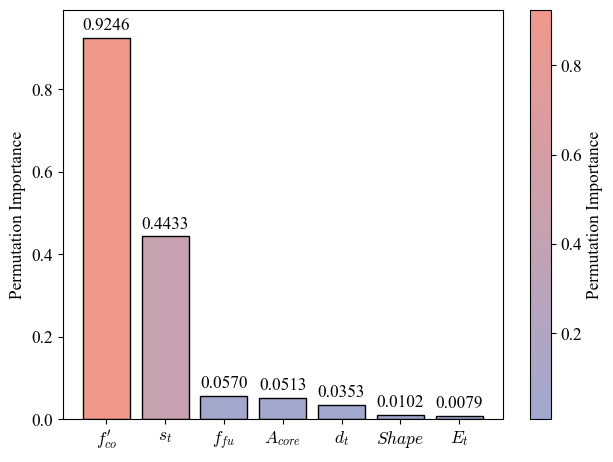

In [23]:
regressor = regs[-1].regs[-1]
from sklearn.inspection import permutation_importance
p_importance = permutation_importance(regressor, x_tar, y_tar, random_state=random_state)
y_fi_42, x_names_42 = sort_lists(p_importance['importances_mean'].tolist(), feature_names)
fig, ax = plt.subplots()
cdict_s, cdict_l = [161, 169, 208], [240, 152, 140]
cdict = {'red': [[0.0, cdict_s[0] / 255, cdict_s[0] / 255],
                 [1.0, cdict_l[0] / 255, cdict_l[0] / 255]],
         'green': [[0.0, cdict_s[1] / 255, cdict_s[1] / 255],
                   [1.0, cdict_l[1] / 255, cdict_l[1] / 255]],
         'blue': [[0.0, cdict_s[2] / 255, cdict_s[2] / 255],
                  [1.0, cdict_l[2] / 255, cdict_l[2] / 255]]}
cmap = matplotlib.colors.LinearSegmentedColormap(name='cmap01', segmentdata=cdict)
norm4plt = plt.Normalize(min(y_fi_42), max(y_fi_42))
c4plt = plt.cm.ScalarMappable(cmap=cmap, norm=norm4plt)
bar1 = ax.bar(x_names_42, y_fi_42, edgecolor='black', color=cmap(norm4plt(y_fi_42)))
ax.set_ylim([0, max(y_fi_42) * 1.075])
cbar = plt.colorbar(c4plt, ax=ax, orientation='vertical', label='Permutation Importance')
ax.set_ylabel('Permutation Importance')
for rect in bar1:
    height = rect.get_height()
    ax.annotate('{0:.4f}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')
fig.tight_layout()
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


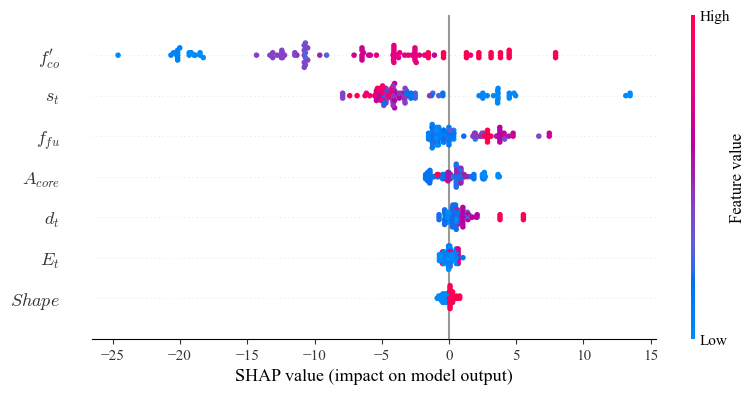

In [24]:
x = pandas.DataFrame(x_tar, columns=feature_names)
explainer = shap.TreeExplainer(regressor)
spv = explainer(x)
shap.plots.beeswarm(spv, show=False, plot_size=(8, 4))
shap.plots._beeswarm.pl.subplots_adjust(top=0.95, bottom=0.14, left=0.12, right=1.0, hspace=0.2, wspace=0.2)
shap.plots._beeswarm.pl.show()